In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)


In [4]:
data = pd.read_csv('Datasets/tested.csv')

In [12]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
data.shape

(418, 12)

In [8]:
missing = data.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing)

Missing values per column:
 Cabin          327
Age             86
Fare             1
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Ticket           0
Embarked         0
dtype: int64


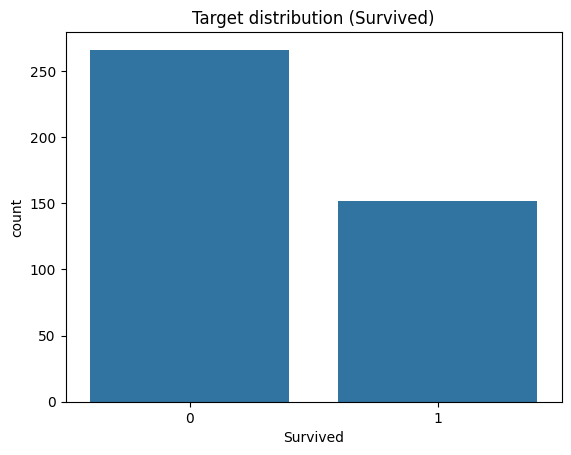

In [9]:
sns.countplot(x='Survived', data=data)
plt.title("Target distribution (Survived)")
plt.show()

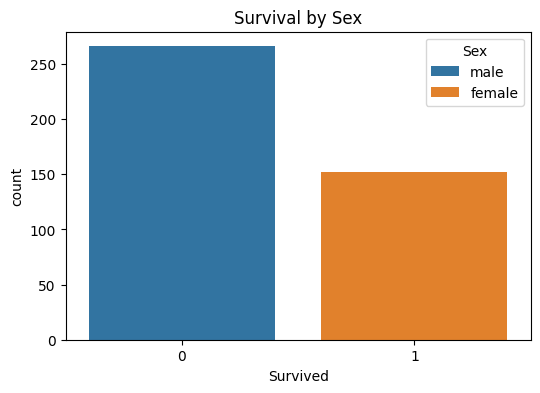

In [10]:
#Survival by Sex
plt.figure(figsize=(6,4))
sns.countplot(x="Survived", hue="Sex", data=data)
plt.title("Survival by Sex")
plt.show()

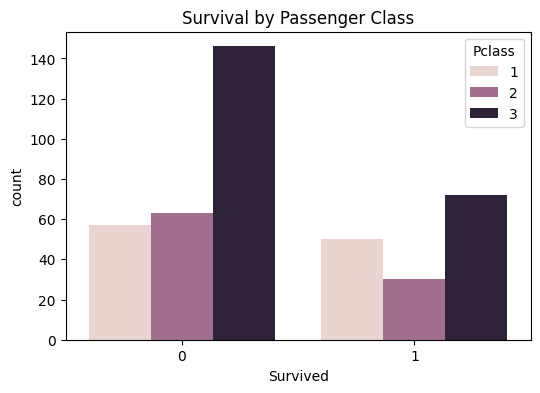

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x="Survived", hue="Pclass", data=data)
plt.title("Survival by Passenger Class")
plt.show()

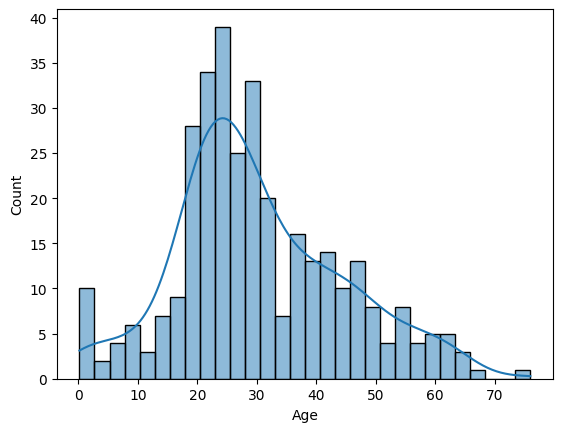

In [13]:
sns.histplot(data['Age'],bins=30,kde=True)
plt.show()

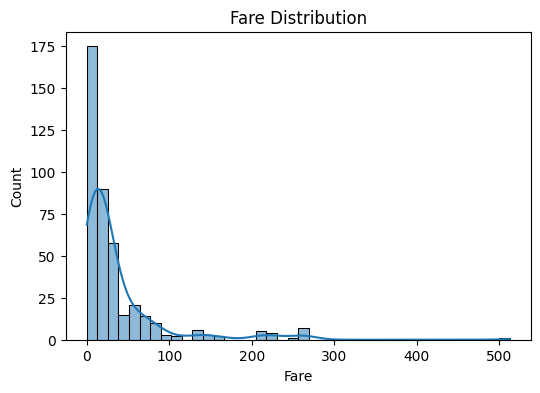

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(data["Fare"], bins=40, kde=True)
plt.title("Fare Distribution")
plt.show()

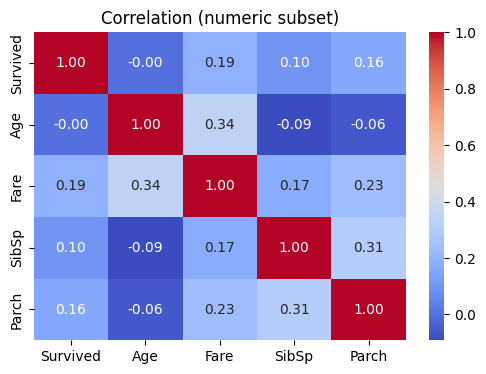

In [15]:
num_cols = ["Age", "Fare", "SibSp", "Parch"]
plt.figure(figsize=(6,4))
sns.heatmap(data[["Survived"] + num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (numeric subset)")
plt.show()

In [16]:
df = data.copy()
df.drop(columns=["Cabin", "Ticket", "PassengerId"], inplace=True, errors="ignore")


In [17]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,0,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


In [18]:
if df["Embarked"].isna().any():
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)


In [19]:
if df["Fare"].isna().any():
    df["Fare"] = df.groupby("Pclass")["Fare"].transform(lambda s: s.fillna(s.median()))


In [20]:
def impute_age(row, med_table):
    if pd.isna(row["Age"]):
        return med_table.loc[row["Sex"], row["Pclass"]]
    return row["Age"]

age_medians = df.groupby(["Sex", "Pclass"])["Age"].median()
df["Age"] = df.apply(lambda r: impute_age(r, age_medians), axis=1)


In [21]:
# Family size & solitude
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)


In [22]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "IsAlone"]
df_model = df[features + ["Survived"]].copy()


In [24]:
X = df_model.drop("Survived", axis=1)
y = df_model["Survived"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (334, 9)  Test shape: (84, 9)


In [25]:
def encode_sex(s):
    if s == "male": return 0
    if s == "female": return 1
    return np.nan

X_train_enc = X_train.copy()
X_test_enc  = X_test.copy()

X_train_enc["Sex"] = X_train_enc["Sex"].apply(encode_sex)
X_test_enc["Sex"]  = X_test_enc["Sex"].apply(encode_sex)


In [26]:
# One-hot on train
X_train_ohe = pd.get_dummies(X_train_enc, columns=["Embarked", "Pclass"], drop_first=True)

# Apply same columns to test: get_dummies then reindex to train columns
X_test_ohe = pd.get_dummies(X_test_enc, columns=["Embarked", "Pclass"], drop_first=True)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)


In [29]:
scaler = StandardScaler()

num_cols_to_scale = ["Age", "Fare", "SibSp", "Parch", "FamilySize"]  # leave IsAlone, dummies as-is

# Fit on train
X_train_ohe[num_cols_to_scale] = scaler.fit_transform(X_train_ohe[num_cols_to_scale])

# Transform test
X_test_ohe[num_cols_to_scale] = scaler.transform(X_test_ohe[num_cols_to_scale])


In [32]:
logreg = LogisticRegression(max_iter=1000, solver="lbfgs")
logreg.fit(X_train_ohe, y_train)

y_pred = logreg.predict(X_test_ohe)
y_prob = logreg.predict_proba(X_test_ohe)[:, 1]


In [34]:
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 1.0


Confusion Matrix:
 [[53  0]
 [ 0 31]]


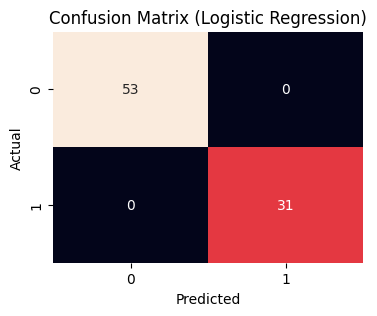

In [35]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


In [37]:
print("Feature Coefficients:")
for feature, coef in zip(X.columns, logreg.coef_[0]):
    print(f"{feature}: {coef}")

# Intercept
print("\nIntercept:", logreg.intercept_[0])

Feature Coefficients:
Pclass: 6.2512368428019665
Sex: -0.0841663195275656
Age: -0.041394817701704195
SibSp: 0.047825076158107355
Parch: 0.1924507992860013
Fare: 0.004167753665621382
Embarked: -0.3665857762577612
FamilySize: 0.2867161180484402
IsAlone: -0.11123351304678895

Intercept: -3.079125742498182
